<a href="https://colab.research.google.com/github/Fadiabdf/OPT/blob/main/TP2/TP2_OPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP2 OPTIM : LES HEURISTIQUES PAR CONSTRUCTION ET PAR AMELIORATION**

## Notre travail pratique comprend quatre heuristiques de construction : le Plus Proche Voisin (PPV), la Plus Proche Insertion (PPI), la Plus Lointaine Insertion (PLI) et la Meilleure Insertion (MI). De plus, nous avons implémenté cinq heuristiques d'amélioration : 2-opt, 3-opt, Or-opt, l'échange de villes (swap_cities) et l'inversion de segments (reverse_segment).

La première étape consiste à construire la matrice des distances, qui représente les coûts de déplacement entre chaque paire de villes. Ensuite, nous définissons et implémentons les algorithmes heuristiques pour résoudre le problème du voyageur de commerce (TSP)

In [ ]:
!pip install tsplib95
!pip install springpy

In [ ]:
import numpy as np
import xml.etree.ElementTree as ET
import time
from math import ceil
import tsplib95
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

Charger un fichier XML, extrait les villes et leurs distances, construit un graphe pondéré, puis affiche le nombre total de villes

In [ ]:
# Charger et parser le fichier XML
instance = 'berlin52.xml'  # Remplace par ton fichier XML
problem = ET.parse(instance)

root = problem.getroot()  # Récupérer la racine du fichier XML

# Initialiser le graphe
graphe = {}

# Extraire les sommets et leurs distances
for i, sommet in enumerate(root.find('graph').findall('vertex')):
    aretes = {}
    for arete in sommet.findall('edge'):
        cible = int(arete.text)  # ID de la ville cible
        cout = float(arete.get('cost'))  # Distance
        aretes[cible] = cout
    graphe[i] = aretes

nombre_sommets = len(graphe)
print(f"Nombre total de villes : {nombre_sommets}")


Nombre total de villes : 52


Initialiser une matrice de distances avec des valeurs infinies, puis la remplit à partir des données du graphe. La diagonale est mise à zéro pour représenter la distance nulle entre une ville et elle-même. Ensuite, un sous-ensemble de la matrice est extrait pour des tests

In [ ]:
# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)  # Convertit en entiers

# Remplir la matrice de distances avec les coûts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# Définir la diagonale à zéro (distance d'un sommet à lui-même)
np.fill_diagonal(matrice_distances, 0)

# Sélectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = 15  # Nombre de sommets à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ultérieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()

# Afficher le sous-ensemble de la matrice
print(sous_ensemble_matrice)

Nombre de nœuds à prendre pour le test : 15
[[   0  666  281  395  291  326  640  426  600  561 1040  655  975 1120
   299]
 [ 666    0  649 1047  945  978   45  956 1134 1132 1638 1258 1440 1515
   957]
 [ 281  649    0  603  508  542  610  308  485  487 1266  891 1247 1399
   504]
 [ 395 1047  603    0  104   69 1026  525  611  533  663  294  711  897
   100]
 [ 291  945  508  104    0   35  923  470  583  513  760  382  769  944
    25]
 [ 326  978  542   69   35    0  957  491  596  523  726  349  744  922
    40]
 [ 640   45  610 1026  923  957    0  918 1095 1095 1627 1245 1440 1521
   935]
 [ 426  956  308  525  470  491  918    0  183  180 1144  812 1234 1414
   452]
 [ 600 1134  485  611  583  596 1095  183    0   83 1165  873 1316 1507
   561]
 [ 561 1132  487  533  513  523 1095  180   83    0 1082  792 1236 1428
   490]
 [1040 1638 1266  663  760  726 1627 1144 1165 1082    0  387  442  619
   762]
 [ 655 1258  891  294  382  349 1245  812  873  792  387    0  452  653
   3

<ipython-input-5-5e13ddbb3846>:3: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


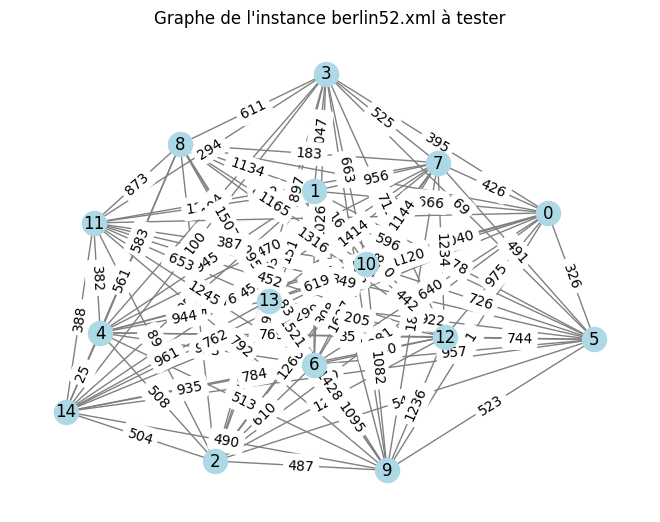

In [ ]:
import networkx as nx

# Créer un graphe à partir de la matrice de distances
G = nx.Graph()
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(len(sous_ensemble_matrice_liste[i])):
        if i != j:
            G.add_edge(i, j, weight= sous_ensemble_matrice_liste[i][j])

# Dessiner le graphe
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graphe de l'instance " +instance+ " à tester")
plt.show()

# **Heuristiques par construction:**

# **Heuristique du plus proche voisin**

**nearest_neighbor_tsp(distance_matrix) :** Cette fonction construit un circuit en partant d'une ville initiale (0), puis en visitant à chaque étape la ville non visitée la plus proche, jusqu'à ce que toutes les villes soient parcourues. Le circuit se termine en retournant à la ville de départ.

**calculate_tour_cost(tour, distance_matrix) :** Cette fonction calcule le coût total du circuit en additionnant les distances entre les villes successives du tour.

In [ ]:
def nearest_neighbor_tsp(distance_matrix):
    """
    Implémente l'algorithme du plus proche voisin pour approximer une solution au problème du voyageur de commerce (TSP).

    Paramètre :
    - distance_matrix : Matrice de distances entre les villes.

    Retourne :
    - tour : Liste représentant l'ordre des villes visitées, avec un retour à la ville de départ.
    """
    n = len(distance_matrix)  # Nombre de villes
    unvisited = set(range(n))  # Ensemble des villes non encore visitées
    tour = []  # Liste pour stocker l'ordre des villes visitées

    # Commencer à la première ville (indice 0)
    current_city = 0
    tour.append(current_city)
    unvisited.remove(current_city)  # Marquer la ville comme visitée

    while unvisited:
        # Trouver la ville non visitée la plus proche
        next_city = min(unvisited, key=lambda city: distance_matrix[current_city][city])
        tour.append(next_city)  # Ajouter cette ville au tour
        unvisited.remove(next_city)  # Marquer cette ville comme visitée
        current_city = next_city  # Déplacer le point de départ vers la nouvelle ville

    # Retourner à la ville de départ pour compléter le circuit
    tour.append(tour[0])

    return tour

def calculate_tour_cost(tour, distance_matrix):
    """
    Calcule le coût total d'un circuit donné en additionnant les distances entre les villes successives.

    Paramètres :
    - tour : Liste de villes représentant l'ordre du circuit.
    - distance_matrix : Matrice des distances entre les villes.

    Retourne :
    - cost : Coût total du circuit.
    """
    cost = 0
    for i in range(len(tour) - 1):
        cost += distance_matrix[tour[i]][tour[i+1]]  # Additionner les distances entre villes successives
    return cost


In [ ]:
distance_matrix = sous_ensemble_matrice_liste

start_time = time.time()
tour = nearest_neighbor_tsp(distance_matrix)
execution_time = time.time() - start_time
cost = calculate_tour_cost(tour, distance_matrix)
print("Instance urilisée : " + instance+ " avec "+ str(n_sous_ensemble) +" noeuds")
print(f"Tour trouvé: {tour}")
print(f"Coût du tour: {cost}")
print(f"Temps d'exécution: {execution_time:.6f} secondes")

Instance urilisée : berlin52.xml avec 15 noeuds
Tour trouvé: [0, 2, 7, 9, 8, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût du tour: 5070
Temps d'exécution: 0.000127 secondes


# L’heuristique d’insertion
Une approche utilisée pour résoudre le problème du voyageur de commerce (TSP) en construisant progressivement un circuit en insérant les villes une par une selon une certaine stratégie. Il existe plusieurs variantes de cette méthode :

### **- PPI (Plus Proche Insertion) :**
À chaque étape, la ville la plus proche d’un point du circuit actuel est insérée à la position optimale, minimisant l’augmentation de la distance totale.


In [ ]:
# Heuristique Plus Proche Insertion (PPI)
def plus_proche_insertion(matrice_dist):
    n = len(matrice_dist)  # Nombre de sommets (villes)
    non_visites = list(range(1, n))  # Liste des villes non visitées (exclut la ville de départ 0)
    tournee = [0]  # La tournée commence au dépôt (ville 0)

    # Trouver le client (ville) le plus proche du dépôt
    premier_client = min(non_visites, key=lambda i: matrice_dist[0][i])
    tournee.append(premier_client)  # Ajouter cette ville à la tournée
    non_visites.remove(premier_client)  # La marquer comme visitée

    while non_visites:
        # Trouver la ville la plus proche de n'importe quelle ville dans la tournée actuelle
        meilleur_client = min(non_visites, key=lambda i: min(matrice_dist[i][j] for j in tournee))

        # Trouver la meilleure position pour insérer cette ville dans la tournée
        meilleur_index = min(
            range(len(tournee)),
            key=lambda j: (
                matrice_dist[tournee[j]][meilleur_client] +  # Distance de la ville actuelle vers la nouvelle
                matrice_dist[meilleur_client][tournee[(j + 1) % len(tournee)]] -  # Distance de la nouvelle vers la suivante
                matrice_dist[tournee[j]][tournee[(j + 1) % len(tournee)]]  # Éviter d'ajouter un coût inutile
            )
        )

        # Insérer la ville trouvée à la position optimale
        tournee.insert(meilleur_index + 1, meilleur_client)
        non_visites.remove(meilleur_client)  # La marquer comme visitée

    # Retourner au dépôt à la fin de la tournée
    tournee.append(0)

    # Retourner la tournée trouvée ainsi que son coût total
    return tournee, calculer_cout(tournee, matrice_dist)

# Fonction pour calculer le coût total d'une tournée
def calculer_cout(tournee, matrice_dist):
    return sum(matrice_dist[tournee[i]][tournee[i+1]] for i in range(len(tournee) - 1))


In [ ]:
start_time = time.time()
tournee_ppi, cout_ppi = plus_proche_insertion(sous_ensemble_matrice)
end_time = time.time()
temps_execution = end_time - start_time
print("\nPlus Proche Insertion (PPI) :")
print(f"Tournée : {tournee_ppi}")
print(f"Coût total : {cout_ppi}")
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))


Plus Proche Insertion (PPI) :
Tournée : [0, 4, 5, 11, 10, 13, 12, 3, 14, 9, 8, 7, 2, 6, 1, 0]
Coût total : 5082
Temps d'exécution : 0.000447 secondes


**- PLI (Plus Loin Insertion) :**
À chaque étape, on insère la ville la plus éloignée du circuit, ce qui favorise une exploration plus large avant d'optimiser les connexions

In [ ]:
# Heuristique Plus Lointaine Insertion (PLI)
def plus_lointaine_insertion(matrice_dist):
    n = len(matrice_dist)  # Nombre de villes
    non_visites = list(range(1, n))  # Liste des villes non visitées (exclut la ville de départ 0)
    tournee = [0]  # La tournée commence au dépôt (ville 0)

    # Sélectionner la ville la plus éloignée du dépôt
    premier_client = max(non_visites, key=lambda i: matrice_dist[0][i])
    tournee.append(premier_client)  # Ajouter cette ville à la tournée
    non_visites.remove(premier_client)  # Marquer la ville comme visitée

    while non_visites:
        # Trouver la ville la plus éloignée des villes déjà visitées
        client_lointain = max(non_visites, key=lambda i: min(matrice_dist[i][j] for j in tournee))

        # Trouver la meilleure position pour insérer cette ville dans la tournée
        meilleur_index = min(
            range(len(tournee)),
            key=lambda j: (
                matrice_dist[tournee[j]][client_lointain] +  # Distance entre la ville actuelle et la nouvelle
                matrice_dist[client_lointain][tournee[(j + 1) % len(tournee)]] -  # Distance entre la nouvelle et la suivante
                matrice_dist[tournee[j]][tournee[(j + 1) % len(tournee)]]  # Éviter une augmentation excessive du coût
            )
        )

        # Insérer la ville trouvée à la position optimale
        tournee.insert(meilleur_index + 1, client_lointain)
        non_visites.remove(client_lointain)  # La marquer comme visitée

    # Retourner au dépôt à la fin de la tournée
    tournee.append(0)

    # Retourner la tournée trouvée ainsi que son coût total
    return tournee, calculer_cout(tournee, matrice_dist)

# Fonction pour calculer le coût total d'une tournée
def calculer_cout(tournee, matrice_dist):
    return sum(matrice_dist[tournee[i]][tournee[i+1]] for i in range(len(tournee) - 1))


In [ ]:
start_time = time.time()
tournee_pli, cout_pli = plus_lointaine_insertion(sous_ensemble_matrice)
end_time = time.time()
temps_execution = end_time - start_time
print("\nPlus Lointaine Insertion (PLI) :")
print(f"Tournée : {tournee_pli}")
print(f"Coût total : {cout_pli}")
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))


Plus Lointaine Insertion (PLI) :
Tournée : [0, 6, 1, 13, 12, 10, 11, 3, 5, 4, 14, 9, 8, 7, 2, 0]
Coût total : 5002
Temps d'exécution : 0.000437 secondes


**- MI (Méthode d’Insertion Minimale) :**
À chaque étape, on insère la ville qui entraîne le plus faible accroissement de la distance totale du circuit.

In [ ]:
# Heuristique Meilleure Insertion (MI)
def meilleure_insertion(matrice_dist):
    n = len(matrice_dist)  # Nombre total de villes
    non_visites = list(range(1, n))  # Liste des villes à visiter (exclut la ville de départ 0)
    tournee = [0]  # La tournée commence au dépôt (ville 0)

    # Sélectionner le client le plus proche du dépôt pour initier la tournée
    premier_client = min(non_visites, key=lambda i: matrice_dist[0][i])
    tournee.append(premier_client)  # Ajouter cette ville à la tournée
    non_visites.remove(premier_client)  # La marquer comme visitée

    while non_visites:
        meilleur_client = None  # Ville qui sera insérée
        meilleur_index = None  # Position optimale d'insertion
        meilleur_gain = float('inf')  # Coût supplémentaire minimum

        # Parcourir toutes les villes non visitées
        for client in non_visites:
            # Tester toutes les positions possibles dans la tournée pour insérer cette ville
            for j in range(len(tournee)):
                # Calculer le coût supplémentaire si on insère cette ville entre tournee[j] et tournee[j+1]
                gain = (matrice_dist[tournee[j]][client] +
                        matrice_dist[client][tournee[(j + 1) % len(tournee)]]) - matrice_dist[tournee[j]][tournee[(j + 1) % len(tournee)]]

                # Si ce coût est le plus faible trouvé jusqu'à présent, on met à jour les meilleurs choix
                if gain < meilleur_gain:
                    meilleur_gain = gain
                    meilleur_client = client
                    meilleur_index = j

        # Insérer la ville sélectionnée à la position optimale trouvée
        tournee.insert(meilleur_index + 1, meilleur_client)
        non_visites.remove(meilleur_client)  # La marquer comme visitée

    # Retourner au dépôt une fois toutes les villes visitées
    tournee.append(0)

    # Retourner la tournée trouvée ainsi que son coût total
    return tournee, calculer_cout(tournee, matrice_dist)

# Fonction pour calculer le coût total d'une tournée
def calculer_cout(tournee, matrice_dist):
    return sum(matrice_dist[tournee[i]][tournee[i+1]] for i in range(len(tournee) - 1))


In [ ]:
start_time = time.time()
tournee_mi, cout_mi = meilleure_insertion(sous_ensemble_matrice)
end_time = time.time()
temps_execution = end_time - start_time
print("\nmeilleure_insertion (mi) :")
print(f"Tournée : {tournee_mi}")
print(f"Coût total : {cout_mi}")
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))


meilleure_insertion (mi) :
Tournée : [0, 4, 5, 11, 10, 13, 12, 3, 14, 9, 8, 7, 2, 6, 1, 0]
Coût total : 5082
Temps d'exécution : 0.000757 secondes


# **Comparaison entre les 3 heuristiques:**

On remarque que l'heuristique de Plus Lointaine Insertion (PLI) a donné les meilleurs résultats parmi ces heuristiques en termes de coût de la tournée, souvent très proche de l'optimal de **Branch and Bound** **(4962)**.

**L'heuristique Plus Lointaine Insertion (PLI)** est efficace car elle privilégie l'ajout des villes les plus éloignées en premier, ce qui aide à structurer le parcours de manière plus optimale. Voici pourquoi cette approche donne un coût très proche de l’optimal :

### **- Meilleure répartition spatiale :**
En insérant d’abord les villes les plus éloignées, l'algorithme évite de créer un parcours concentré dans une seule région, ce qui pourrait entraîner de longs détours en fin de construction.
Cela permet une meilleure couverture de l’espace dès les premières étapes.

### **- Réduction des détours inutiles :**
En insérant les villes éloignées tôt dans le processus, on évite de devoir les intégrer plus tard dans un itinéraire déjà structuré, ce qui limiterait les choix d’insertion et augmenterait la distance totale parcourue.

### **- Construction progressive optimisée :**
Chaque nouveau ville est insérée à la position qui minimise l’augmentation du coût total, ce qui garantit une amélioration progressive du chemin.
Contrairement aux heuristiques qui insèrent les clients proches en premier, PLI réduit le risque de mauvais placements précoces qui pourraient dégrader la solution finale.

# **Heuristiques par Amélioration:**

# **2-Opt (Échange de 2 arêtes)**

**Principe de 2-opt:**

L'idée de 2-opt  est d'améliorer une tournée en échangeant deux arêtes pour réduire la longueur totale du circuit. Cela se fait en inversant un segment de la tournée , ce qui peut supprimer des croisements inefficaces.

**Étapes de l'algorithme**

Choisir deux arêtes non adjacentes  dans la tournée.

Exemple : Soit la tournée [A → B → C → D → E].

On choisit les arêtes (B → C) et (D → E).

Inverser le segment entre ces deux arêtes  :
La nouvelle tournée devient [A → B → D → C → E].

Vérifier si la nouvelle tournée est meilleure  :
Calculer la différence de coût entre l'ancienne et la nouvelle tournée.

Si la nouvelle tournée est plus courte, accepter le changement.

Répéter  jusqu'à ce qu'aucune amélioration ne soit possible.

**Logique derrière l'inversion:**

Lorsque deux arêtes se croisent (ex. B → C et D → E), inverser le segment entre elles permet de "décroiser" la tournée, réduisant ainsi la distance totale.

L'inversion locale n'affecte que les villes entre les deux arêtes choisies, ce qui rend l'opération rapide à évaluer.

**Avantages:**  
**Simple et efficace**  : Facile à implémenter et donne souvent des résultats proches de l'optimal.

**Localité**  : Se concentre sur des modifications locales sans recalculer toute la tournée.

In [ ]:
def two_opt(tour, distance_matrix):
    """
    Améliore le tour initial par l'heuristique 2-opt.
    Le tour est une liste avec la ville de départ répétée à la fin.
    """
    # Pour faciliter les opérations, on retire la dernière ville répétée
    base_tour = tour[:-1]
    n = len(base_tour)
    best_cost = calculate_tour_cost(tour, distance_matrix)
    improved = True
    iteration = 0
    while improved:
        improved = False
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                # Inverser le segment entre i et j
                new_tour = base_tour[:i] + base_tour[i:j+1][::-1] + base_tour[j+1:]
                candidate_tour = new_tour + [new_tour[0]]
                candidate_cost = calculate_tour_cost(candidate_tour, distance_matrix)
                if candidate_cost < best_cost:
                    base_tour = new_tour
                    best_cost = candidate_cost
                    improved = True
                    iteration += 1
                    print(f"Amélioration itération {iteration}: nouveau coût = {best_cost:.2f}")
                    break  # On applique la première amélioration trouvée
            if improved:
                break
    return base_tour + [base_tour[0]]

# **3-Opt (Échange de 3 arêtes)**

**Principe:**
Le 3-Opt est une heuristique d'amélioration pour le problème du voyageur de commerce (TSP). Il consiste à :

Couper la tournée actuelle en 3 segments en choisissant trois points de coupure (i, j, k).

Réorganiser les segments de différentes manières (inverser un ou plusieurs segments).

Calculer le coût de chaque nouvelle tournée candidate.

Accepter la première amélioration qui réduit le coût total de la tournée.

Le processus est répété jusqu'à ce qu'aucune amélioration ne soit possible.


In [ ]:
def three_opt(tour, distance_matrix):
    """
    Améliore le tour initial par l'heuristique 3-opt.
    Le tour est une liste avec la ville de départ répétée à la fin.
    """
    # Pour faciliter les opérations, on retire la dernière ville répétée
    base_tour = tour[:-1]
    n = len(base_tour)
    best_cost = calculate_tour_cost(tour, distance_matrix)
    improved = True
    iteration = 0

    while improved:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                for k in range(j + 1, n):
                    # Générer les nouvelles tournées candidates en inversant les segments
                    # Option 1 : Inverser le segment entre i et j
                    option1 = base_tour[:i] + base_tour[i:j+1][::-1] + base_tour[j+1:]
                    candidate_tour1 = option1 + [option1[0]]
                    candidate_cost1 = calculate_tour_cost(candidate_tour1, distance_matrix)

                    # Option 2 : Inverser le segment entre j et k
                    option2 = base_tour[:i] + base_tour[i:j+1] + base_tour[j+1:k+1][::-1] + base_tour[k+1:]
                    candidate_tour2 = option2 + [option2[0]]
                    candidate_cost2 = calculate_tour_cost(candidate_tour2, distance_matrix)

                    # Option 3 : Inverser les segments entre i et j, et entre j et k
                    option3 = base_tour[:i] + base_tour[i:j+1][::-1] + base_tour[j+1:k+1][::-1] + base_tour[k+1:]
                    candidate_tour3 = option3 + [option3[0]]
                    candidate_cost3 = calculate_tour_cost(candidate_tour3, distance_matrix)

                    # Trouver la meilleure option
                    best_candidate_cost = min(candidate_cost1, candidate_cost2, candidate_cost3)

                    # Si une amélioration est trouvée, appliquer la meilleure option
                    if best_candidate_cost < best_cost:
                        if best_candidate_cost == candidate_cost1:
                            base_tour = option1
                        elif best_candidate_cost == candidate_cost2:
                            base_tour = option2
                        elif best_candidate_cost == candidate_cost3:
                            base_tour = option3

                        best_cost = best_candidate_cost
                        improved = True
                        iteration += 1
                        print(f"Amélioration itération {iteration}: nouveau coût = {best_cost:.2f}")
                        break  # On applique la première amélioration trouvée
                if improved:
                    break  # Sortir de la boucle intermédiaire
            if improved:
                break  # Sortir de la boucle externe

    return base_tour + [base_tour[0]]

# **Or-Opt (Déplacement de segments)**
**Explication :**

L'algorithme Or-Opt est une heuristique d'amélioration qui consiste à déplacer un segment de la tournée (une séquence de villes) à une autre position dans la tournée. L'objectif est de réduire la longueur totale de la tournée en réorganisant les segments.

**Détails :**

Parcourez tous les segments possibles de la tournée (de longueur 1 à 3).

Pour chaque segment, essayez de le déplacer à toutes les positions possibles dans la tournée.

Si le déplacement réduit la longueur totale de la tournée, effectuez le déplacement.

In [ ]:
def or_opt(tour, distance_matrix):
    """
    Améliore le tour initial par l'heuristique Or-Opt.
    Le tour est une liste avec la ville de départ répétée à la fin.
    """
    # Pour faciliter les opérations, on retire la dernière ville répétée
    base_tour = tour[:-1]
    n = len(base_tour)
    best_cost = calculate_tour_cost(tour, distance_matrix)
    improved = True
    iteration = 0

    while improved:
        improved = False
        for segment_length in range(1, 4):  # Longueurs de segments : 1, 2 ou 3
            for i in range(1, n - segment_length):
                segment = base_tour[i:i+segment_length]
                for j in range(1, n - segment_length + 1):
                    if j == i:
                        continue  # Ne pas déplacer le segment à la même position

                    # Créer une nouvelle tournée en déplaçant le segment
                    new_tour = base_tour[:i] + base_tour[i+segment_length:]
                    new_tour[j:j] = segment
                    candidate_tour = new_tour + [new_tour[0]]
                    candidate_cost = calculate_tour_cost(candidate_tour, distance_matrix)

                    # Si une amélioration est trouvée, appliquer la nouvelle tournée
                    if candidate_cost < best_cost:
                        base_tour = new_tour
                        best_cost = candidate_cost
                        improved = True
                        iteration += 1
                        print(f"Amélioration itération {iteration}: nouveau coût = {best_cost:.2f}")
                        break  # On applique la première amélioration trouvée
                if improved:
                    break  # Sortir de la boucle intermédiaire
            if improved:
                break  # Sortir de la boucle externe

    return base_tour + [base_tour[0]]

# **Échange de villes (Swap)**
**Explication :**

L'heuristique d'échange de villes consiste à échanger la position de deux villes dans la tournée pour réduire la longueur totale. Cette heuristique est simple mais peut être efficace pour des améliorations locales.

**Détails :**

Parcourez toutes les paires de villes dans la tournée.

Pour chaque paire, vérifiez si l'échange des positions réduit la longueur totale de la tournée.

Si c'est le cas, effectuez l'échange et continuez jusqu'à ce qu'aucune amélioration ne soit possible.

In [ ]:
def swap_cities(tour, distance_matrix):
    """
    Améliore le tour initial par l'heuristique d'échange de villes.
    Le tour est une liste avec la ville de départ répétée à la fin.
    """
    # Pour faciliter les opérations, on retire la dernière ville répétée
    base_tour = tour[:-1]
    n = len(base_tour)
    best_cost = calculate_tour_cost(tour, distance_matrix)
    improved = True
    iteration = 0

    while improved:
        improved = False
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                # Créer une nouvelle tournée en échangeant les villes i et j
                new_tour = base_tour.copy()
                new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
                candidate_tour = new_tour + [new_tour[0]]
                candidate_cost = calculate_tour_cost(candidate_tour, distance_matrix)

                # Si une amélioration est trouvée, appliquer la nouvelle tournée
                if candidate_cost < best_cost:
                    base_tour = new_tour
                    best_cost = candidate_cost
                    improved = True
                    iteration += 1
                    print(f"Amélioration itération {iteration}: nouveau coût = {best_cost:.2f}")
                    break  # On applique la première amélioration trouvée
            if improved:
                break  # Sortir de la boucle externe

    return base_tour + [base_tour[0]]

# **Inversion de segments (Segment Reverse)**
**Explication :**

L'heuristique d'inversion de segments consiste à inverser l'ordre d'un segment de la tournée pour réduire la longueur totale. Cette heuristique est similaire à 2-Opt mais se concentre sur l'inversion de segments plutôt que sur l'échange d'arêtes.

**Détails :**

Parcourez tous les segments possibles de la tournée.

Pour chaque segment, inversez-le et vérifiez si cela réduit la longueur totale de la tournée.

Si c'est le cas, effectuez l'inversion et continuez jusqu'à ce qu'aucune amélioration ne soit possible.

In [ ]:
def reverse_segment(tour, distance_matrix):
    """
    Améliore le tour initial par l'heuristique d'inversion de segments.
    Le tour est une liste avec la ville de départ répétée à la fin.
    """
    # Pour faciliter les opérations, on retire la dernière ville répétée
    base_tour = tour[:-1]
    n = len(base_tour)
    best_cost = calculate_tour_cost(tour, distance_matrix)
    improved = True
    iteration = 0

    while improved:
        improved = False
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                # Créer une nouvelle tournée en inversant le segment entre i et j
                new_tour = base_tour[:i] + base_tour[i:j+1][::-1] + base_tour[j+1:]
                candidate_tour = new_tour + [new_tour[0]]
                candidate_cost = calculate_tour_cost(candidate_tour, distance_matrix)

                # Si une amélioration est trouvée, appliquer la nouvelle tournée
                if candidate_cost < best_cost:
                    base_tour = new_tour
                    best_cost = candidate_cost
                    improved = True
                    iteration += 1
                    print(f"Amélioration itération {iteration}: nouveau coût = {best_cost:.2f}")
                    break  # On applique la première amélioration trouvée
            if improved:
                break  # Sortir de la boucle externe

    return base_tour + [base_tour[0]]

# **Application de ces heuristiques**

On applique ces heuristiques d'amélioration aprés avoir généré une solution initiale avec **l'une des heuristiques par construction**



# **2_OPT:**


In [ ]:
start_time = time.time()
tour_initial = nearest_neighbor_tsp(distance_matrix)
cost_initial = calculate_tour_cost(tour_initial, distance_matrix)
temps_initial = time.time() - start_time

print("\n--- Solution initiale (Plus Proche Voisin) ---")
print(f"Tour initial : {tour_initial}")
print(f"Coût initial : {cost_initial:.2f}")
print(f"Temps d'exécution (initial) : {temps_initial:.6f} secondes")

# Amélioration par 2-opt
start_time_improvement = time.time()
tour_ameliore = two_opt(tour_initial, distance_matrix)
cost_ameliore = calculate_tour_cost(tour_ameliore, distance_matrix)
temps_improvement = time.time() - start_time_improvement

print("\n--- Résultats après amélioration 2-opt ---")
print(f"Tour amélioré : {tour_ameliore}")
print(f"Coût du tour amélioré : {cost_ameliore:.2f}")
print(f"Temps d'exécution de l'amélioration : {temps_improvement:.6f} secondes")


--- Solution initiale (Plus Proche Voisin) ---
Tour initial : [0, 2, 7, 9, 8, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût initial : 5070.00
Temps d'exécution (initial) : 0.000128 secondes
Amélioration itération 1: nouveau coût = 5043.00
Amélioration itération 2: nouveau coût = 4975.00
Amélioration itération 3: nouveau coût = 4962.00

--- Résultats après amélioration 2-opt ---
Tour amélioré : [0, 13, 12, 10, 11, 3, 5, 4, 14, 9, 8, 7, 2, 6, 1, 0]
Coût du tour amélioré : 4962.00
Temps d'exécution de l'amélioration : 0.000662 secondes


# **3_OPT:**

In [ ]:
# Tester la fonction three_opt avec la solution initiale de Nearest Neighbor
start_time = time.time()
initial_tour = nearest_neighbor_tsp(distance_matrix)
initial_cost = calculate_tour_cost(initial_tour, distance_matrix)
print("\nSolution initiale (Plus Proche Voisin) :")
print(f"Tournée : {initial_tour}")
print(f"Coût total : {initial_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")

# Appliquer three_opt
start_time = time.time()
improved_tour = three_opt(initial_tour.copy(), distance_matrix)
improved_cost = calculate_tour_cost(improved_tour, distance_matrix)
print("\nAmélioration avec three_opt :")
print(f"Tournée améliorée : {improved_tour}")
print(f"Coût total amélioré : {improved_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")


Solution initiale (Plus Proche Voisin) :
Tournée : [0, 2, 7, 9, 8, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût total : 5070
Temps d'exécution : 0.000285 secondes
Amélioration itération 1: nouveau coût = 5002.00
Amélioration itération 2: nouveau coût = 4975.00
Amélioration itération 3: nouveau coût = 4962.00

Amélioration avec three_opt :
Tournée améliorée : [0, 13, 12, 10, 11, 3, 5, 4, 14, 9, 8, 7, 2, 6, 1, 0]
Coût total amélioré : 4962
Temps d'exécution : 0.003560 secondes


# **Or_Opt:**

In [ ]:
# Tester la fonction Or_opt avec la solution initiale de Nearest Neighbor
start_time = time.time()
initial_tour = nearest_neighbor_tsp(distance_matrix)
initial_cost = calculate_tour_cost(initial_tour, distance_matrix)
print("\nSolution initiale (Plus Proche Voisin) :")
print(f"Tournée : {initial_tour}")
print(f"Coût total : {initial_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")

# Appliquer Or_opt
start_time = time.time()
improved_tour = or_opt(initial_tour.copy(), distance_matrix)
improved_cost = calculate_tour_cost(improved_tour, distance_matrix)
print("\nAmélioration avec or_opt :")
print(f"Tournée améliorée : {improved_tour}")
print(f"Coût total amélioré : {improved_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")


Solution initiale (Plus Proche Voisin) :
Tournée : [0, 2, 7, 9, 8, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût total : 5070
Temps d'exécution : 0.000299 secondes
Amélioration itération 1: nouveau coût = 5002.00

Amélioration avec or_opt :
Tournée améliorée : [0, 2, 7, 8, 9, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût total amélioré : 5002
Temps d'exécution : 0.000973 secondes


# **Swap_cities:**

In [ ]:
# Tester la fonction Swap_cities avec la solution initiale de Nearest Neighbor
start_time = time.time()
initial_tour = nearest_neighbor_tsp(distance_matrix)
initial_cost = calculate_tour_cost(initial_tour, distance_matrix)
print("\nSolution initiale (Plus Proche Voisin) :")
print(f"Tournée : {initial_tour}")
print(f"Coût total : {initial_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")

# Appliquer Swap_cities
start_time = time.time()
improved_tour = swap_cities(initial_tour.copy(), distance_matrix)
improved_cost = calculate_tour_cost(improved_tour, distance_matrix)
print("\nAmélioration avec swap_cities :")
print(f"Tournée améliorée : {improved_tour}")
print(f"Coût total amélioré : {improved_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")


Solution initiale (Plus Proche Voisin) :
Tournée : [0, 2, 7, 9, 8, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût total : 5070
Temps d'exécution : 0.000303 secondes
Amélioration itération 1: nouveau coût = 5002.00

Amélioration avec swap_cities :
Tournée améliorée : [0, 2, 7, 8, 9, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût total amélioré : 5002
Temps d'exécution : 0.000345 secondes


# **reverse_segment:**

In [ ]:
# Tester la fonction reverse_segment avec la solution initiale de Nearest Neighbor
start_time = time.time()
initial_tour = nearest_neighbor_tsp(distance_matrix)
initial_cost = calculate_tour_cost(initial_tour, distance_matrix)
print("\nSolution initiale (Plus Proche Voisin) :")
print(f"Tournée : {initial_tour}")
print(f"Coût total : {initial_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")

# Appliquer reverse_segment
start_time = time.time()
improved_tour = reverse_segment(initial_tour.copy(), distance_matrix)
improved_cost = calculate_tour_cost(improved_tour, distance_matrix)
print("\nAmélioration avec reverse_segment :")
print(f"Tournée améliorée : {improved_tour}")
print(f"Coût total amélioré : {improved_cost}")
print(f"Temps d'exécution : {time.time() - start_time:.6f} secondes")


Solution initiale (Plus Proche Voisin) :
Tournée : [0, 2, 7, 9, 8, 14, 4, 5, 3, 11, 10, 12, 13, 1, 6, 0]
Coût total : 5070
Temps d'exécution : 0.000279 secondes
Amélioration itération 1: nouveau coût = 5043.00
Amélioration itération 2: nouveau coût = 4975.00
Amélioration itération 3: nouveau coût = 4962.00

Amélioration avec reverse_segment :
Tournée améliorée : [0, 13, 12, 10, 11, 3, 5, 4, 14, 9, 8, 7, 2, 6, 1, 0]
Coût total amélioré : 4962
Temps d'exécution : 0.000731 secondes


# **Comparaison entre les 5 heuristiques par amélioration:**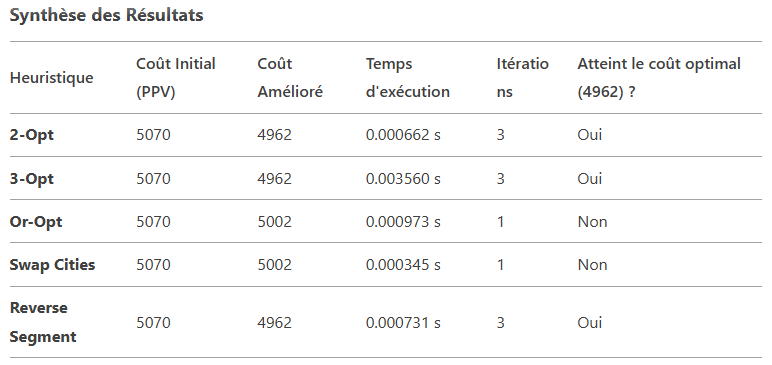

## **Analyse Globale**

- **Performance en termes de coût :**

Les heuristiques 2-Opt, 3-Opt et Reverse Segment atteignent le coût optimal de 4962, identique à la méthode de Branch and Bound.

Les heuristiques Or-Opt et Swap Cities n'atteignent pas le coût optimal, avec un coût final de 5002.

- **Performance en termes de temps :**

Swap Cities est la plus rapide (0.000345 s), suivie de 2-Opt (0.000662 s) et Reverse Segment (0.000731 s).

3-Opt est la plus lente (0.003560 s) en raison de sa complexité accrue.

- **Itérations nécessaires :**

2-Opt, 3-Opt et Reverse Segment nécessitent 3 itérations pour atteindre le coût optimal.

Or-Opt et Swap Cities n'ont besoin que d'une seule itération, mais n'atteignent pas le coût optimal.

**Conclusion**

Les heuristiques d'amélioration 2-Opt, 3-Opt et Reverse Segment sont les plus performantes, atteignant le coût optimal de 4962 tout en restant rapides. Or-Opt et Swap Cities, bien que rapides, ne parviennent pas à atteindre le coût optimal, ce qui les rend moins adaptées pour des solutions de haute précision.

# **Comparaison entre les heuristiques par construction vs par amélioration:**

 - **Performance en termes de coût :**

Les heuristiques de construction (PPV, PPI, PLI, MI) génèrent des solutions initiales de qualité variable, mais aucune n'atteint le coût optimal.

Les heuristiques d'amélioration (2-Opt, 3-Opt, Reverse Segment) atteignent le coût optimal de 4962.

- **Performance en termes de temps :**

Les heuristiques de construction sont généralement plus rapides que les heuristiques d'amélioration.

- **Qualité de la solution :**

Les heuristiques de construction fournissent une base pour les heuristiques d'amélioration, mais elles ne sont pas suffisantes pour atteindre le coût optimal.

Les heuristiques d'amélioration sont essentielles pour atteindre des solutions de haute qualité.

## **Conclusion**

**Heuristiques de construction :**

Rapides mais génèrent des solutions de qualité moyenne.

Idéales pour fournir une solution initiale rapidement.

**Heuristiques d'amélioration :**

Plus lentes mais capables d'atteindre des solutions de haute qualité.

Essentielles pour améliorer les solutions initiales.